https://www.kaggle.com/datasets/google-brain/messidor2-dr-grades

In [97]:
!tree -d ../

../
├── dataset
│   ├── IMAGES
│   └── original_zip_file
└── script

4 directories


In [98]:
!ls ../dataset/

data_label.csv	IMAGES	messidor_data.csv  original_zip_file


In [199]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import cv2
import tqdm
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings(action='ignore')

In [100]:
data_info = pd.read_csv('../dataset/messidor_data.csv')

In [101]:
data_info.tail()

,image_id,adjudicated_dr_grade,adjudicated_dme,adjudicated_gradable
1743,IM004806.jpg,0.0,0.0,1
1744,IM004811.jpg,1.0,0.0,1
1745,IM004812.jpg,2.0,0.0,1
1746,IM004831.jpg,0.0,0.0,1
1747,IM004832.jpg,0.0,0.0,1


In [102]:
## null값 여부
data_info.isnull().sum()

image_id                0
adjudicated_dr_grade    4
adjudicated_dme         4
adjudicated_gradable    0
dtype: int64

In [106]:
data_info[data_info['adjudicated_dme'].isnull()]['image_id']

692     20060411_58550_0200_PP.png
1413                  IM002385.jpg
1596                  IM003718.jpg
1658                  IM004176.jpg
Name: image_id, dtype: object

In [122]:
## JPG2jpg
for file_name in glob.glob('../dataset/IMAGES/*.JPG'):
    file = os.path.splitext(file_name)[0]
    os.rename(file_name , f'{file}.jpg' )

In [123]:
## labeling안되어있는 null값 제거
for file_name in data_info[data_info['adjudicated_dme'].isnull()]['image_id']:
    os.remove(f'../dataset/IMAGES/{file_name}')

In [125]:
print('제거 후 데이터 개수 :' ,len(os.listdir('../dataset/IMAGES/')))

제거 후 데이터 개수 : 1744


In [161]:
data_info = data_info[data_info['adjudicated_dme'].notnull()]

In [162]:
## data type 변환
data_info['adjudicated_dme'] = data_info['adjudicated_dme'].astype('int')
data_info['adjudicated_dr_grade'] = data_info['adjudicated_dr_grade'].astype('int')

In [163]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 1747
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   image_id              1744 non-null   object
 1   adjudicated_dr_grade  1744 non-null   int64 
 2   adjudicated_dme       1744 non-null   int64 
 3   adjudicated_gradable  1744 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 68.1+ KB


In [47]:
## Data 확장자 type
print( 'data 확장자 종류 :' ,set(data_info.image_id.map(lambda x : os.path.splitext(x)[1])))

data 확장자 종류 : {'.jpg', '.png'}


In [59]:
data_info.columns

Index(['image_id', 'adjudicated_dr_grade', 'adjudicated_dme',
       'adjudicated_gradable'],
      dtype='object')

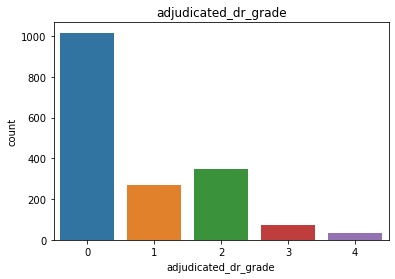

adjudicated_dr_grade
0    1017
1     270
2     347
3      75
4      35
Name: adjudicated_dr_grade, dtype: int64


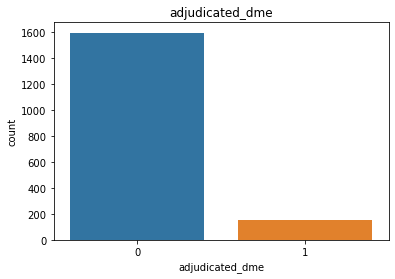

adjudicated_dme
0    1593
1     151
Name: adjudicated_dme, dtype: int64


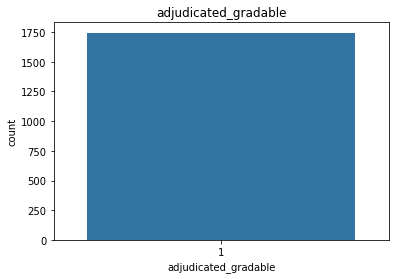

adjudicated_gradable
1    1744
Name: adjudicated_gradable, dtype: int64


In [61]:
for column in data_info.columns[1:]:
    sns.countplot(data_info[column])
    plt.title(column)
    plt.show()
    print(data_info[column].groupby(data_info[column]).count())

In [164]:
## 이진 분류 변환
data_info['target'] = data_info['adjudicated_dr_grade'].map(lambda x : 0 if (x == 0 or x == 1) else 1)

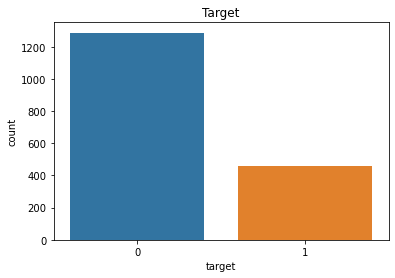

target
0    1287
1     457
Name: target, dtype: int64
class 1 ratio 0.26


In [86]:
## 이진분류 이후 histogram
sns.countplot(data_info['target'])
plt.title('Target')
plt.show()
print(data_info['target'].groupby(data_info['target']).count())
print('class 1 ratio %.2f' % (data_info['target'].mean()))

In [175]:
data_target = data_info[['image_id' , 'target' ]].reset_index().drop('index' , axis = 1  )

In [126]:
data_dir = '../dataset/IMAGES/'
file_paths = os.listdir('../dataset/IMAGES/')

In [141]:
## image shape , channel 개수 확인
image_list = []
df = pd.DataFrame(columns = ['x' , 'y' , 'c','file_path'])
for file_path in tqdm.tqdm(file_paths):
    image = cv2.imread(data_dir + file_path)
    image = np.array(image)
    df = df.append({'x' :  image.shape[0] ,
                    'y' :  image.shape[1] ,
                    'c' :  image.shape[2] ,
                    'file_path' : file_path} , ignore_index = True)

100%|██████████| 1744/1744 [01:00<00:00, 28.69it/s]


In [149]:
df.tail()

,x,y,c,file_path
1739,1488,2240,3,IM003229.jpg
1740,1536,2304,3,IM000220.jpg
1741,960,1440,3,20051110_38313_0400_PP.png
1742,1488,2240,3,IM004036.jpg
1743,1488,2240,3,20051021_52127_0100_PP.png


In [148]:
print('채널이 3이 아닌 것 :' ,(df['c'] != 3).sum())

채널이 3이 아닌 것 : 0


In [159]:
print('x값 최소 , 최대 :' ,df['x'].min() , df['x'].max())
print('y값 최소 , 최대 :' ,df['y'].min() , df['y'].max())

x값 최소 , 최대 : 960 1536
y값 최소 , 최대 : 1440 2304


In [185]:
class_0_image_path = data_target[data_target['target'] == 0][:4]['image_id']
class_1_image_path = data_target[data_target['target'] == 1][:4]['image_id']

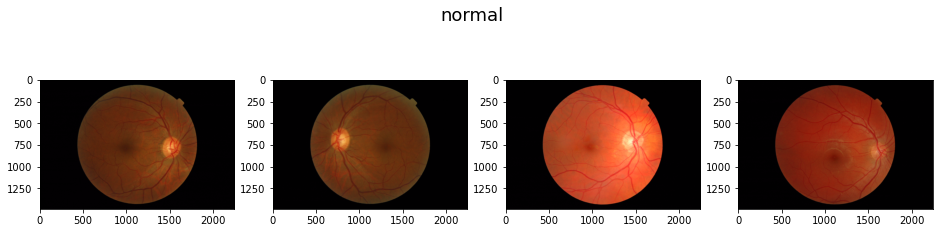

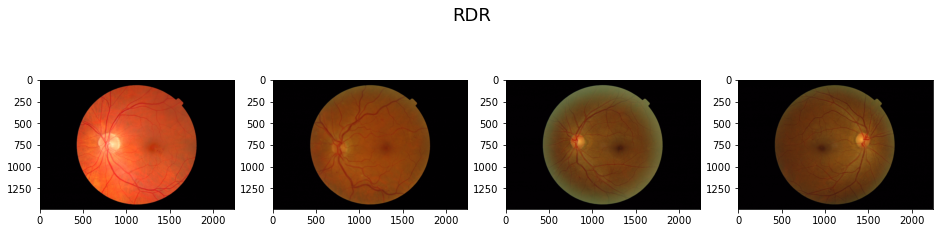

In [198]:
fig , ax = plt.subplots(1 , 4 , figsize = (16 , 4))
c = 0
for image_path in class_0_image_path:
    image = cv2.imread(data_dir + image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image)
    ax[c].imshow(image)
    plt.suptitle('normal'  , fontsize = 18 )
    c += 1
plt.show()

c = 0
fig , ax = plt.subplots(1 , 4 , figsize = (16 , 4))
for image_path in class_1_image_path:
    image = cv2.imread(data_dir + image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image)
    ax[c].imshow(image)
    plt.suptitle('RDR'  , fontsize = 18 )
    c += 1
plt.show()

In [200]:
## 층화추출
kf = StratifiedKFold(n_splits = 5 , shuffle = True , random_state = 42)

In [205]:
data_target['fold'] = -1
for idx , (t , v) in enumerate(kf.split(data_target , data_target['target']) , 1):
    data_target.loc[v , 'fold'] = idx

In [228]:
data_target.loc[data_target['fold'] != 1 , 'type'] = 'train'
data_target.loc[data_target['fold'] == 1 , 'type'] = 'val'

In [230]:
data_target.to_csv('../dataset/data_label.csv' , index = False)

In [236]:
train_data = data_target[data_target['type'] == 'train']['image_id']

## RGB값 추출

In [250]:
RGB = []
for image_path in tqdm.tqdm(train_data):
    image = cv2.imread('../dataset/IMAGES/' + image_path)
    B = (image[:, : , 0] / 255.).mean()
    G = (image[:, : , 1] / 255.).mean()
    R = (image[:, : , 2] / 255.).mean()

    B_std = (image[:, : , 0] / 255.).std()
    G_std = (image[:, : , 1] / 255.).std()
    R_std = (image[:, : , 2] / 255.).std()
    RGB.append([R , G , B , R_std ,G_std , B_std])

100%|██████████| 1395/1395 [01:32<00:00, 15.13it/s]


In [251]:
RGBnSTD = np.array(RGB).mean(axis = 1)

In [252]:
print('meanRGB :' ,RGBnSTD[0] , RGBnSTD[1] , RGBnSTD[2])
print('stdRGB :' ,RGBnSTD[3] , RGBnSTD[4]  , RGBnSTD[5] )

meanRGB : 0.11281195415254214 0.1140350906773473 0.2175441003327727
stdRGB : 0.13166954453899374 0.1222213793337753 0.13156050053393406
